In [92]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

from farich_functions import *

plt.rcParams['font.size'] = 12

In [19]:
warnings.filterwarnings("ignore")

In [20]:
filepath = os.path.join("data", "decay_test_ka2.root")

In [21]:
file = uproot.open(filepath)

In [22]:
primary_pdgid = np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.pdgId'].array())

In [23]:
farich_pdgid = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.pdgId'].array()) # 40% К куда-то пропадают в фариче

In [24]:
i = 0
empty_farich = 0
important_particle_ind = 3
mismatches = []
good_events = []
good_mu_events = []
good_ka_events = []
primary_particle_idx = []
primary_particle_in_primary_idx = []
no_mu_in_mu = []
no_ka = []
# find_index = lambda arr: (idx[-1]+1 if (idx := np.flatnonzero(arr == -22)).size and (idx[-1]+1 < arr.size) else 0) # моржовый оператор :)
find_index = lambda arr: (idx[-1] + 1 if (idx := np.flatnonzero(np.isin(arr, [-22, -11]))).size and (idx[-1] + 1 < arr.size) else 0)
find_index_mu = lambda arr: (idx[-1] if (idx := np.flatnonzero(arr == -13)).size and (idx[-1] < arr.size) else False)
find_index_ka = lambda arr: (idx[-1] if (idx := np.flatnonzero(arr == -321)).size and (idx[-1] < arr.size) else False)

# need 2 rings per event now...

for primary_particles in primary_pdgid:
    is_good = True
                
    if farich_pdgid[i].shape[0] == 0 or np.flatnonzero(farich_pdgid[i] + 22).shape[0] == 0:
        empty_farich += 1
        is_good = False
    if primary_particles[0] != 30443:
        print('First wrong')
        is_good = False
    if primary_particles[1] != 421: # 411
        print('Second wrong')
        is_good = False
    if primary_particles[2] != -321:
        print('Third wrong')
        is_good = False
        
    if primary_particles[2] == -321 and is_good:
        if farich_pdgid[i].shape[0] != 0 and np.flatnonzero(farich_pdgid[i] + 22).shape[0] != 0:
            if find_index_ka(farich_pdgid[i]) is not False:
                if primary_particles[2] != farich_pdgid[i][find_index_ka(farich_pdgid[i])]:
                    print('Mismatch', i)
                    mismatches.append(i)
                    is_good = False
            else:
                print('No ka in event', i)
                is_good = False
                no_ka.append(i)
        if is_good:
            good_events.append(i)
            primary_particle_idx.append(find_index_ka(farich_pdgid[i]))
            primary_particle_in_primary_idx.append(2)
            
            
    if primary_particles[important_particle_ind] == -13 and is_good:
        if farich_pdgid[i].shape[0] != 0 and np.flatnonzero(farich_pdgid[i] + 22).shape[0] != 0:
            if find_index_mu(farich_pdgid[i]) is not False:
                if primary_particles[important_particle_ind] != farich_pdgid[i][find_index_mu(farich_pdgid[i])]:
                    print('Mismatch', i)
                    mismatches.append(i)
                    is_good = False
            else:
                print('No mu in mu event', i)
                is_good = False
                no_mu_in_mu.append(i)
        if is_good:
            good_events.append(i)
            primary_particle_idx.append(find_index_mu(farich_pdgid[i]))
            primary_particle_in_primary_idx.append(important_particle_ind)
        if not is_good:
            if len(good_events) != 0:
                good_events.pop()
                primary_particle_idx.pop()
                primary_particle_in_primary_idx.pop()
    

    # if is_good:
    #     good_events.append(i)
    #     primary_particle_idx.append(find_index(farich_pdgid[i]))
    i += 1
    

print('Empty Farich:',empty_farich)
print('Mismatches: ',len(mismatches))
print('Missing K: ',len(no_ka))
print('Missing Mu in Mu event: ',len(no_mu_in_mu))
print('Full bad events: ', len(mismatches) + empty_farich + len(set(np.concatenate([no_mu_in_mu, no_ka]))))
print('Good Events:', i - len(mismatches) - empty_farich - len(set(np.concatenate([no_mu_in_mu, no_ka]))))
print(len(good_events))
print(len(set(good_events)))
print(- len(set(good_events)) + len(good_events))

No ka in event 1
No mu in mu event 2
No ka in event 4
No ka in event 6
No ka in event 12
No ka in event 13
No ka in event 14
No ka in event 15
No ka in event 16
No ka in event 18
No ka in event 21
No ka in event 22
No ka in event 23
No ka in event 28
No ka in event 31
No ka in event 33
No ka in event 36
No ka in event 37
No ka in event 38
No ka in event 42
No ka in event 43
No ka in event 45
No ka in event 48
No mu in mu event 50
No ka in event 51
No ka in event 56
No ka in event 58
No ka in event 59
No ka in event 63
No ka in event 64
No mu in mu event 67
No ka in event 72
No ka in event 74
No ka in event 79
No ka in event 80
No ka in event 81
No ka in event 82
No ka in event 84
No ka in event 86
No ka in event 89
No ka in event 93
No ka in event 94
No ka in event 97
No mu in mu event 98
No ka in event 99
No ka in event 100
No ka in event 106
No mu in mu event 110
No ka in event 111
No ka in event 112
No ka in event 114
No ka in event 115
No ka in event 118
No ka in event 119
No ka in

In [25]:
farich_energy = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.energy'].array())[good_events]
farich_momentum_x = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.momentum.px'].array())[good_events]
farich_momentum_y = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.momentum.py'].array())[good_events]
farich_momentum_z = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.momentum.pz'].array())[good_events]

primary_momentum_x = np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.px'].array())[good_events]
primary_momentum_y = np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.py'].array())[good_events]
primary_momentum_z = np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.pz'].array())[good_events]

farich_x = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']["FarichBarrelG4Hits.postStepPosition.x"].array())[good_events]
farich_y = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']["FarichBarrelG4Hits.postStepPosition.y"].array())[good_events]
farich_z = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']["FarichBarrelG4Hits.postStepPosition.z"].array())[good_events]
farich_t = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']["FarichBarrelG4Hits.localTime"].array())[good_events]

In [26]:
np.sum([primary_pdgid[i][2] == -321 for i in range(10000)]) 

10000

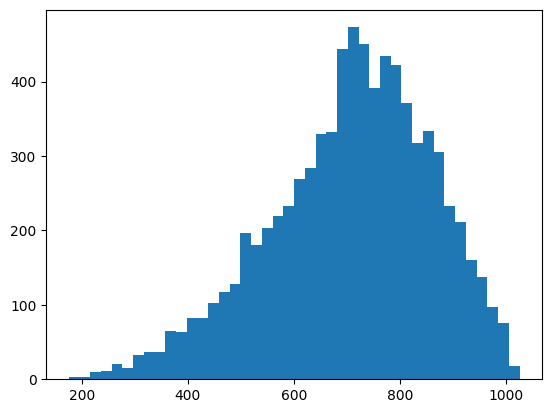

In [27]:
plt.hist([np.sqrt((primary_momentum_x[i][2]) ** 2 + (primary_momentum_y[i][2]) ** 2 + (primary_momentum_z[i][2]) ** 2) * 1000 for i in range(len(good_events))], bins='auto')
plt.show()

In [28]:
def init_coords_decay(file, grid):
    x = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']["FarichBarrelG4Hits.postStepPosition.x"].array())[good_events]
    y = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']["FarichBarrelG4Hits.postStepPosition.y"].array())[good_events]
    z = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']["FarichBarrelG4Hits.postStepPosition.z"].array())[good_events]
    wvs = (1239.841 / np.array(file[file.keys()[0]]['FarichBarrelG4Hits']["FarichBarrelG4Hits.energy"].array()) * 1e-9)[good_events]
    t = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']["FarichBarrelG4Hits.localTime"].array())[good_events]
    
    farich_momentum_x = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.momentum.px'].array())[good_events]
    farich_momentum_y = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.momentum.py'].array())[good_events]
    farich_momentum_z = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.momentum.pz'].array())[good_events]
    farich_pdgid =      np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.pdgId'].array())[good_events]
        
    x3 = np.array([farich_momentum_x[i][primary_particle_idx[i]] for i in range(farich_momentum_x.shape[0])])
    y3 = np.array([farich_momentum_y[i][primary_particle_idx[i]] for i in range(farich_momentum_y.shape[0])])
    z3 = np.array([farich_momentum_z[i][primary_particle_idx[i]] for i in range(farich_momentum_z.shape[0])])
    id = np.array([farich_pdgid[i][primary_particle_idx[i]] for i in range(farich_pdgid.shape[0])])
  
    xi = np.array([x[i][primary_particle_idx[i]] for i in range(x.shape[0])])
    yi = np.array([y[i][primary_particle_idx[i]] for i in range(y.shape[0])])
    zi = np.array([z[i][primary_particle_idx[i]] for i in range(z.shape[0])])
    
    x3 = np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.px'].array())[good_events]
    y3 = np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.py'].array())[good_events]
    z3 = np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.pz'].array())[good_events]
    x3 = np.array([x3[i][primary_particle_in_primary_idx[i]] for i in range(len(good_events))])
    y3 = np.array([y3[i][primary_particle_in_primary_idx[i]] for i in range(len(good_events))])
    z3 = np.array([z3[i][primary_particle_in_primary_idx[i]] for i in range(len(good_events))])
    # Объединяем массивы, сохраняя структуру массивов
    true_direction_coordinates = np.stack((x3, y3, z3), axis=1)
    intersections = np.stack((xi, yi, zi), axis=1)
    for i in range(len(wvs)):
        wvs[i] = lin_move_to_grid(wvs[i], grid[2])
    coordinates = np.column_stack((x, y, z, wvs, t))
    return coordinates, true_direction_coordinates, intersections, id


In [29]:
datadir = "data"
sipm_eff, PDE_wvs = init_sipm_eff()
for key in sipm_eff.keys():
    sipm_eff[key] = sipm_eff[key] / 0.55414 * 0.38

x_grid = np.arange(
    -3 * norm_r * np.sin(np.pi / 27),
    3 * norm_r * np.sin(np.pi / 27),
    SIPM_CELL_SIZE,
)
z_grid = np.arange(-1400, 1400, SIPM_CELL_SIZE)
grid = (x_grid, z_grid, PDE_wvs)

decay_file = uproot.open(filepath)
coordinates, true_direction_coordinates, intersections, ids = init_coords_decay(
    decay_file, grid
)


In [30]:
intersections / np.linalg.norm(intersections, axis=1)[:, None] * np.linalg.norm(true_direction_coordinates, axis=1)[:, None]

array([[ 0.49400845,  0.46695158, -0.32004154],
       [-0.37547314, -0.48471576, -0.5920265 ],
       [ 0.28605416,  0.16623537,  0.1641188 ],
       ...,
       [ 0.16258612, -0.55150247,  0.07975789],
       [ 0.00072456,  0.41843048, -0.36699966],
       [-0.32155937,  0.2185532 ,  0.48274177]], dtype=float32)

In [31]:
def find_cylinder_intersections(vectors, R=1000):
    # vectors - массив размерности (N, 3)
    # R - радиус цилиндра
    
    # Вычисляем t для каждого вектора
    a_x = vectors[:, 0]
    a_y = vectors[:, 1]
    denominator = np.sqrt(a_x**2 + a_y**2)
    
    # Избегаем деления на ноль (векторы, параллельные оси z)
    mask = denominator != 0
    t = np.zeros_like(denominator)
    t[mask] = R / denominator[mask]
    
    # Вычисляем координаты пересечения
    intersections = vectors * t[:, np.newaxis]
    
    return intersections


In [32]:
intersection_diffs = np.sqrt(np.sum((find_cylinder_intersections(intersections, R=1000) - intersections) ** 2, axis=1))

In [33]:
intersection_diffs[intersection_diffs > 100].shape 

(0,)

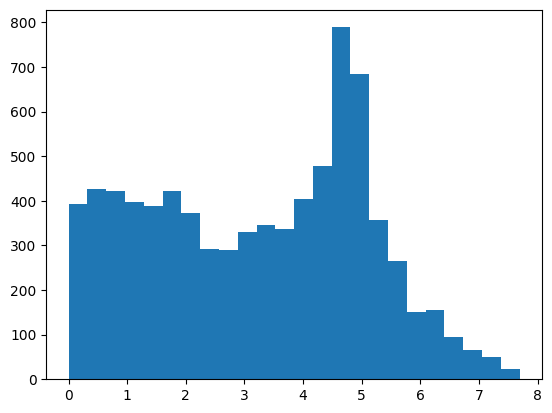

In [34]:
plt.hist(intersection_diffs[intersection_diffs < 100], bins='auto') # Короче, просто используем intersections, координаты важнее
plt.show() 

In [35]:
def shift_index(idx):
    idx = round(idx)
    if idx > 20:
        return idx - 27
    elif idx < -20:
        return idx + 27
    else:
        return idx


In [36]:
def rotate_event_for_decay(coords, main_angle):
    
    # extra_ring = 0
    
    angles = np.arctan2(coords[1], coords[0]) % (2 * np.pi)
    angles = lin_move_to_grid(angles, plane_angles)
    idx_to_shift = (angles - main_angle) / 0.2327
    idx_to_shift = np.array([round(shift_index(idx)) for idx in idx_to_shift])
    # if len(idx_to_shift[np.abs(idx_to_shift) > 5]) > 0:
    #     print(idx_to_shift)
    #     extra_ring = 1
    angle_to_rotate = np.pi / 2 - angles
    x = rotate_point(coords, angle_to_rotate) - 2 * idx_to_shift * norm_r * np.sin(
        np.pi / 27
    )
    return np.column_stack((x, np.zeros_like(x) + 1000, coords[2], coords[3]))


def rotate_events_for_decay(full_coords, main_angles):
    # extra_rings_counter = 0
    for i in range(full_coords.shape[0]):
        event_coords = full_coords[i]
        rotated_event_coords= rotate_event_for_decay(event_coords, main_angles[i])
        # extra_rings_counter += extra_ring
        for j in range(4):
            full_coords[i][j] = rotated_event_coords[:, j]
    # print(extra_rings_counter / full_coords.shape[0])

In [37]:
def find_intersections_for_decay(full_coords):
    intersections = np.zeros((full_coords.shape[0], 3))
    zeros = np.zeros((1, 3))
    for i in range(full_coords.shape[0]):
        event_coords = full_coords[i] / 1000
        pca = PCA(n_components=1)

        # if event_coords[0].shape[0] == 1:
        # print(event_coords)
        event_coords = [[0, arr] for arr in event_coords]
        # print(event_coords)
        pca.fit(np.column_stack(event_coords))
        line_direction = pca.components_[0]
        line_point = pca.mean_

        # Calculate the parameter t for the intersection with the plane y=1000
        p_y = line_point[1]
        d_y = line_direction[1]
        t = (1000 - p_y) / d_y

        # Find the intersection point
        intersection_point = line_point + t * line_direction

        # print(f"Line direction: {line_direction}")
        # print(f"Point on the line: {line_point}")
        # print(f"Intersection point with the plane y=1000: {intersection_point}")
        for j in range(3):
            intersections[i][j] = intersection_point[j]
    return intersections


In [38]:
def rotate_lines_for_decay(full_coords):
    angles = np.zeros(full_coords.shape[0])
    for i in range(full_coords.shape[0]):
        event_coords = full_coords[i]
        rotated_event_coords, angles[i] = rotate_line_for_decay(event_coords)

        for j in range(3):
            full_coords[i][j] = rotated_event_coords[:, j]
    return angles


def rotate_line_for_decay(coords):
    angles = np.arctan2(coords[1], coords[0]) % (2 * np.pi)
    # print(angles)
    try:
        median_angle = angles
    except IndexError:
        print(angles)
        median_angle = np.median(angles)
    median_angle = lin_move_to_grid(np.array([median_angle]), plane_angles)
    # print(angles)
    angle_to_rotate = np.pi / 2 - median_angle
    # print(angle_to_rotate)
    x, y = rotate_point_on_line(coords, angle_to_rotate)
    return np.column_stack((x, y, coords[2])), median_angle


In [39]:
def create_edf_decay(
    filepath="fullsim_optical_2000_pi_bin_1_FARICH_35mm_no_no_trackers.root",
    uncertain_angle=False,
):
    datadir = "data"
    sipm_eff, PDE_wvs = init_sipm_eff()
    for key in sipm_eff.keys():
        sipm_eff[key] = sipm_eff[key] / 0.55414 * 0.38

    x_grid = np.arange(
        -3 * norm_r * np.sin(np.pi / 27),
        3 * norm_r * np.sin(np.pi / 27),
        SIPM_CELL_SIZE,
    )
    z_grid = np.arange(-1400, 1400, SIPM_CELL_SIZE)
    grid = (x_grid, z_grid, PDE_wvs)

    decay_file = uproot.open(os.path.join(datadir, filepath))
    coordinates, true_direction_coordinates, intersections, ids = init_coords_decay(
        decay_file, grid
    )
    
    
    idx_to_drop = []
    for i in range(coordinates.shape[0]):
        if coordinates[i][0].shape[0] == 0:
            idx_to_drop.append(i)

    coordinates = np.delete(coordinates, idx_to_drop, axis=0)
    true_direction_coordinates = np.delete(
        true_direction_coordinates, idx_to_drop, axis=0
    )
    intersections = np.delete(intersections, idx_to_drop, axis=0)
    ids = np.delete(ids, idx_to_drop)
    print(coordinates.shape)
    print(true_direction_coordinates.shape)

    true_direction_coordinates = intersections / np.linalg.norm(intersections, axis=1)[:, None] * np.linalg.norm(true_direction_coordinates, axis=1)[:, None]

    if uncertain_angle:
        uncertainty_introduction_to_direction(true_direction_coordinates)
    
    sipm_sim(coordinates, sipm_eff)

    idx_to_drop = []
    for i in range(coordinates.shape[0]):
        if coordinates[i][0].shape[0] == 0:
            idx_to_drop.append(i)
    coordinates = np.delete(coordinates, idx_to_drop, axis=0)
    true_direction_coordinates = np.delete(
        true_direction_coordinates, idx_to_drop, axis=0
    )
    intersections = np.delete(intersections, idx_to_drop, axis=0)
    ids = np.delete(ids, idx_to_drop)
    print(coordinates.shape)
    print(true_direction_coordinates.shape)

    main_angles = rotate_lines_for_decay(intersections) # Rotates intersection points
    
    intersections = find_intersections_for_decay(intersections)  # May need to rewrite both to treat elements as scalasrs and to change reference point from 0
    
    rotate_events_for_decay(coordinates, main_angles)   # There are events with extra rings somewhere around angle idx 13-16
    move_events_to_grid(coordinates, grid)
    repeat_nums = np.array([coord[0].shape[0] for coord in coordinates])
    edf = pd.DataFrame(coordinates, columns=["x_c", "y_c", "z_c", "wv_c", "t_c"])

    unraveled_data = {col: [] for col in edf.columns}
    row_indices = []

    # Iterate over the DataFrame and unravel the arrays
    for i, row in edf.iterrows():
        max_length = max(len(row[col]) for col in edf.columns)
        for k in range(max_length):
            row_indices.append((i, k))
            for col in edf.columns:
                if k < len(row[col]):
                    unraveled_data[col].append(row[col][k])
                else:
                    unraveled_data[col].append(
                        np.nan
                    )  # Handle cases where arrays are of different lengths

    # Create a new DataFrame from the unraveled data
    unraveled_df = pd.DataFrame(unraveled_data)

    # Create a MultiIndex for the rows
    multi_index = pd.MultiIndex.from_tuples(row_indices, names=["entry", "subentry"])
    unraveled_df.index = multi_index

    edf = unraveled_df

    edf["x_i"] = np.repeat(intersections[:, 0], repeat_nums, axis=0)
    edf["z_i"] = np.repeat(intersections[:, 2], repeat_nums, axis=0)

    x = y = z = x3 = y3 = z3 = unraveled_data = row_indices   = wvs = coordinates = file = coordinates_low = file_low = 0 # = main_angles

    bdf = pd.DataFrame()
    gdf = pd.DataFrame()
    gdf["nhits"] = repeat_nums

    mu_mass = 105.65
    pi_mass = 139.57
    ka_mass = 493.68
    # mass = mu_mass if is_mu else (ka_mass if is_ka else pi_mass)
    mass = np.array([mu_mass if ids[i] == -13 else ka_mass for i in range(ids.shape[0])])
    # edf.drop("y_c", axis=1, inplace=True)
    edf.rename(columns={"y_c": "tmp_c"}, inplace=True)
    edf.drop("wv_c", axis=1, inplace=True)
    edf.rename(columns={"z_c": "y_c", "z_i": "y_i"}, inplace=True)
    edf.rename(columns={"tmp_c": "z_c"}, inplace=True)
    # edf["z_c"] = np.zeros(edf.shape[0]) + 1000  
    # edf["mass"] = np.ones(edf.shape[0]) * mass
    edf["mass"] = np.repeat(
        mass,
        repeat_nums,
        axis=0,
    )
    edf["true_p"] = np.repeat(
        np.linalg.norm(true_direction_coordinates.astype("float"), axis=1) * 1000,
        repeat_nums,
        axis=0,
    )
    edf["beta"] = edf.true_p / np.sqrt(edf.mass**2 + edf.true_p**2)
    edf["x_p"] = np.zeros(edf.shape[0])
    edf["y_p"] = np.zeros(edf.shape[0])
    edf["z_p"] = np.zeros(edf.shape[0])
    edf["nx_p"] = np.repeat(
        (
            intersections
            / np.array(
                [
                    np.linalg.norm(intersections.astype("float"), axis=1)
                    for i in range(3)
                ]
            ).T
        ).astype("float")[:, 0],
        repeat_nums,
        axis=0,
    )
    edf["ny_p"] = np.repeat(
        (
            intersections
            / np.array(
                [
                    np.linalg.norm(intersections.astype("float"), axis=1)
                    for i in range(3)
                ]
            ).T
        ).astype("float")[:, 2],
        repeat_nums,
        axis=0,
    )
    edf["nz_p"] = np.repeat(
        (
            intersections
            / np.array(
                [
                    np.linalg.norm(intersections.astype("float"), axis=1)
                    for i in range(3)
                ]
            ).T
        ).astype("float")[:, 1],
        repeat_nums,
        axis=0,
    )

    true_direction_coordinates = repeat_nums = true_direction_coordinates_low = mass = intersections = 0
    return edf, bdf, gdf, main_angles


In [40]:
edf, bdf, gdf, main_angles_tmp = create_edf_decay('decay_test_ka2.root')

(7931, 5)
(7931, 3)
(6607, 5)
(6607, 3)


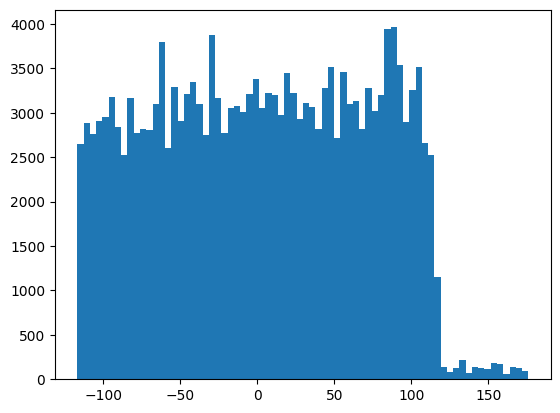

In [41]:
plt.hist(edf.x_i, bins='auto')
plt.show()

In [42]:
edf[(edf.x_c<-350.7) | (edf.x_c>348)].x_c.shape[0] / edf.shape[0] * 100 # 4% всех фотонов - диаметрально противоположные кольца, так же в 4% событий есть лишнее кольцо

65.71166105280739

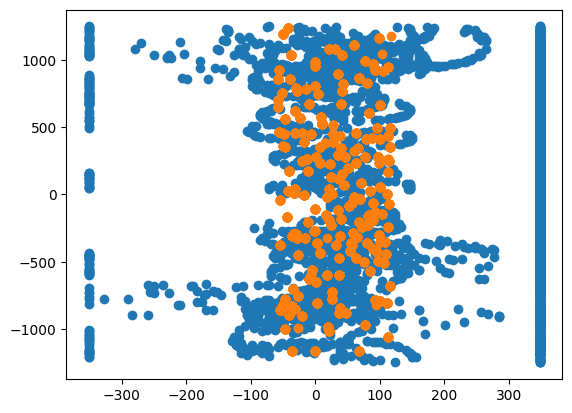

In [43]:
ev = np.where(main_angles_tmp > 6.2)[0]

plt.scatter(edf.loc[ev]["x_c"], edf.loc[ev]["y_c"])
plt.scatter(edf.loc[ev]["x_i"], edf.loc[ev]["y_i"])
plt.show()

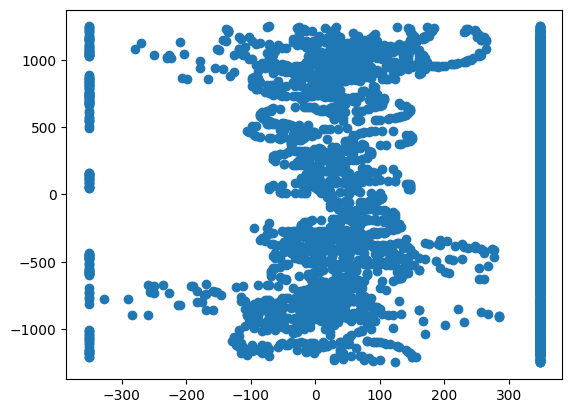

In [44]:
plt.scatter(edf.loc[ev]["x_c"], edf.loc[ev]["y_c"])
# plt.scatter(edf.loc[ev]["x_i"], edf.loc[ev]["z_i"])
plt.show()

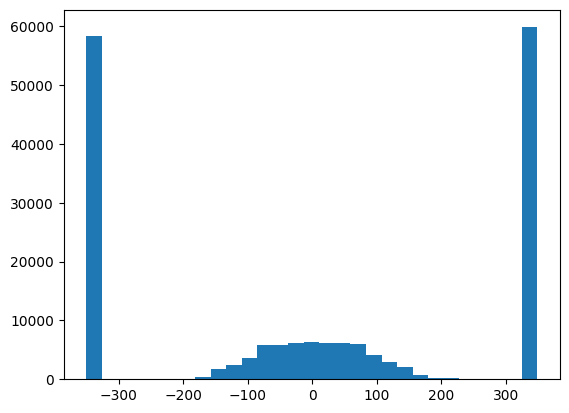

In [45]:
plt.hist(edf.x_c, bins='auto')
plt.show()

In [46]:
(np.arctan2(true_direction_coordinates[0][1], true_direction_coordinates[0][0]))

0.758029

In [47]:
true_direction_coordinates[0][1]

0.46772215

In [48]:
true_direction_coordinates

array([[ 0.4940517 ,  0.46772215, -0.31884745],
       [-0.3756756 , -0.48469853, -0.59191203],
       [ 0.2861253 ,  0.16604821,  0.16418424],
       ...,
       [ 0.1656054 , -0.55053085,  0.08025655],
       [ 0.00076977,  0.4177175 , -0.36781085],
       [-0.3213317 ,  0.21879323,  0.4827847 ]], dtype=float32)

In [49]:
np.linalg.norm(true_direction_coordinates, axis=1) * 1000

array([751.342  , 852.30554, 369.3185 , ..., 580.47437, 556.5729 ,
       619.8432 ], dtype=float32)

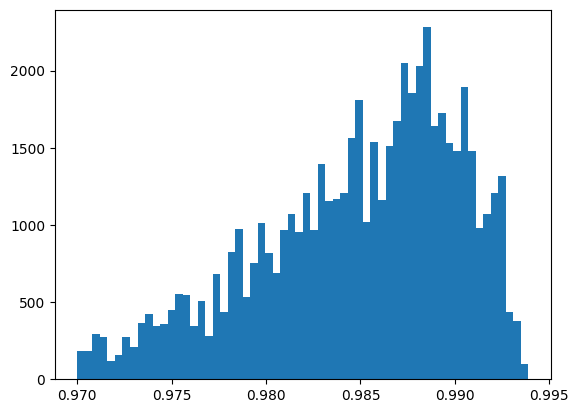

In [50]:
plt.hist(edf[edf.beta>0.97].beta, bins='auto')
plt.show()

In [51]:
edf[edf.beta<.98].shape[0] / edf.shape[0] * 100  # 0.3% событий со странной бетой 

74.81947498816915

In [52]:
edf[edf.beta<.97]

x_c     z_c      y_c       t_c         x_i         y_i  \
entry subentry                                                                  
0     0        -350.719869  1000.0   310.24  0.729966  115.929354 -473.961303   
      1        -350.719869  1000.0   360.64  0.747380  115.929354 -473.961303   
      2        -350.719869  1000.0   263.20  0.673564  115.929354 -473.961303   
      3        -350.719869  1000.0   249.76  0.647891  115.929354 -473.961303   
      4        -350.719869  1000.0   269.92  0.684663  115.929354 -473.961303   
...                    ...     ...      ...       ...         ...         ...   
6605  6        -350.719869  1000.0  1207.36  0.923085    1.730658 -877.086327   
      7        -350.719869  1000.0  1187.20  0.789817    1.730658 -877.086327   
      8        -350.719869  1000.0  1160.32  0.749394    1.730658 -877.086327   
      9        -350.719869  1000.0  1177.12  0.716890    1.730658 -877.086327   
      10       -350.719869  1000.0  1180.48  0.748977    1.730658 -877.086327   

                  mass      true_p      beta  x_p  y_p  z_p      nx_p  \
entry subentry                                                          
0     0         493.68  751.341941  0.835736  0.0  0.0  0.0  0.104188   
      1         493.68  751.341941  0.835736  0.0  0.0  0.0  0.104188   
      2         493.68  751.341941  0.835736  0.0  0.0  0.0  0.104188   
      3         493.68  751.341941  0.835736  0.0  0.0  0.0  0.104188   
      4         493.68  751.341941  0.835736  0.0  0.0  0.0  0.104188   
...                ...         ...       ...  ...  ...  ...       ...   
6605  6         493.68  556.572850  0.748111  0.0  0.0  0.0  0.001301   
      7         493.68  556.572850  0.748111  0.0  0.0  0.0  0.001301   
      8         493.68  556.572850  0.748111  0.0  0.0  0.0  0.001301   
      9         493.68  556.572850  0.748111  0.0  0.0  0.0  0.001301   
      10        493.68  556.572850  0.748111  0.0  0.0  0.0  0.001301   

                    ny_p      nz_p  
entry subentry                      
0     0        -0.425960  0.898723  
      1        -0.425960  0.898723  
      2        -0.425960  0.898723  
      3        -0.425960  0.898723  
      4        -0.425960  0.898723  
...                  ...       ...  
6605  6        -0.659392  0.751798  
      7        -0.659392  0.751798  
      8        -0.659392  0.751798  
      9        -0.659392  0.751798  
      10       -0.659392  0.751798  

[123214 rows x 15 columns]

In [53]:
def enforce_float32(df):
    return df.astype({col: np.float32 for col in df.select_dtypes(include=['float64']).columns})

In [54]:
idf = pd.DataFrame()
idf['W'] = [35.]
# idf['W'] = [40.]

idf['zdis'] = [800.]
idf['distance'] = [205.]  # 200
idf['n_mean'] = [1.04511]
# 
# idf['n_mean'] = [1.0502]

idf['pixel_size'] = [3.16]
mu_mass = 105.65
pi_mass = 139.57
ka_mass = 493.68

In [55]:
mu_pi_ka = True
if mu_pi_ka:
    edf_mu, bdf_mu, gdf_mu = create_edf('fullsim_3particles_2000_mu_bin_1_FARICH_35mm_no_no_trackers.root', sample_num=None, num_of_files=11,
                               uncertain_angle=False, is_mu=True, is_ka=False)
    edf_pi, bdf_pi, gdf_pi = create_edf('fullsim_3particles_2000_pi_bin_1_FARICH_35mm_no_no_trackers.root', sample_num=None, num_of_files=10,
                               uncertain_angle=False, is_mu=False, is_ka=False)
    edf_ka, bdf_ka, gdf_ka = create_edf('fullsim_3particles_2000_ka_bin_1_FARICH_35mm_no_no_trackers.root', sample_num=None, num_of_files=10,
                                    uncertain_angle=False, is_mu=False, is_ka=True)
    
    shift_ind = np.array(edf_mu.index.get_level_values(0))[-1] + 1
    new_index = edf_pi.index.map(lambda idx: (idx[0] + shift_ind, idx[1]))
    edf_pi.index = pd.MultiIndex.from_tuples(new_index, names=edf_mu.index.names)
    gdf_pi.index = np.array(gdf_pi.index) + np.array(gdf_mu.index)[-1] + 1

    shift_ind = np.array(edf_pi.index.get_level_values(0))[-1] + 1
    new_index = edf_ka.index.map(lambda idx: (idx[0] + shift_ind, idx[1]))
    edf_ka.index = pd.MultiIndex.from_tuples(new_index, names=edf_pi.index.names)
    gdf_ka.index = np.array(gdf_ka.index) + np.array(gdf_pi.index)[-1] + 1


    edf_conc = pd.concat([edf_mu, edf_pi, edf_ka])
    gdf_conc = pd.concat([gdf_mu, gdf_pi, gdf_ka])
    
    edf_mu = gdf_mu = edf_ka = gdf_ka = edf_pi = gdf_pi = 0
    edf_conc = enforce_float32(edf_conc)

(22000, 5)
(22000, 3)
(21100, 5)
(21100, 3)
(19993, 5)
(19993, 3)
(19873, 5)
(19873, 3)
(19986, 5)
(19986, 3)
(19857, 5)
(19857, 3)


In [56]:
avg_sigmas = (4, 5)
avg_t_sigmas = (4, 5)
num_of_groups = 10
what_to_group = 'beta'
r_width = float(idf.pixel_size.iloc[0]) * 2
t_width = 0.25
t_step = 0.25
r_factor = 2 # not to change
t_factor = int(t_width / t_step)
weighed = True
deg_lim = False
param_fit = False
useuse_decision_tree = True


calibration_func = pol # pol
param_calibration_func = pol2_pol2 # d3pol2
p0 = (0.9, -5, 340) # (.95, 0, 300) #(.01, 1e-3, 1e-4)
p0_c =  (1.219, -0.5588, 0.2946, 864.4, -1922, 1055, -2535, 6572, -3751)
num_of_calibration_params = 3 # 3
num_of_param_fit_params = 3 # for param fit both prev and this number are important, cal_func as well, therefore p0 and p0_C
target_variable = 'beta'
target_angle = 'theta_p'
num_of_theta_intervals = 11 # 11


# sample_size = 12
cal_arr = False
errs = False

beta_sigms = []
beta_sigms_yerr = []
beta_sigms_deglim = []
beta_sigms_yerr_deglim = []


r_bins = np.arange(16, 80, step=3.3)
r_bins = np.array([[r_bins[i], r_bins[i + 2]] for i in range(len(r_bins) - 2)])
t_bins = np.arange(0, 7, step=0.25)
t_bins = np.array([[t_bins[i], t_bins[i + 1]] for i in range(len(t_bins) - 1)])

background_means_dict = {'1e6': 0.012, '1e5': 0.0015}
background_stds_dict = {'1e6': 0.0175, '1e5': 0.0055}

background_mean = background_means_dict['1e5']
background_std = background_stds_dict['1e5']

batch_size = 10000
num_of_classes = 4

In [57]:
dcr = '0'
print(dcr)
timer_start = perf_counter()
edf_d = edf_conc.copy()
gdf_d = gdf_conc.copy()
bdf_d = pd.DataFrame()
edf_d = addNoise(idf, edf_d, gdf_d, (0, 7), float(dcr))
edf_d = applySpaceCut(edf_d)
planeRecalculation(edf_d, idf)
planeRotation(edf_d)
edf_d = applySecondSpaceCut(edf_d)
edf_to_bdf(edf_d.mass, bdf_d)
edf_to_bdf(edf_d.true_p, bdf_d)
bdf_d.rename(columns={'true_p': 'momentum'}, inplace=True)
edf_to_bdf(edf_d.beta, bdf_d)
recoAngles(edf_d, idf)
primaryDirectionRecalculation(edf_d)

recoAngles(edf_d, idf, rotation_mode=True)

calculateSignalCounts(edf_d, bdf_d)

cal_arr, errs = rSlidingWindow(edf_d, idf, bdf_d, avg_sigmas=avg_sigmas, avg_t_sigmas=avg_t_sigmas, cal_arr=cal_arr, errs=errs, num_of_groups=num_of_groups,
                           step=r_width, t_window_width=t_width, r_width_factor=r_factor, t_width_factor=t_factor, weighed=weighed, deg_lim=deg_lim, param_fit=param_fit,
                           calibration_func=calibration_func, param_calibration_func=param_calibration_func, num_of_calibration_params=num_of_calibration_params, num_of_param_fit_params=num_of_param_fit_params,
                           target_variable=target_variable, target_angle=target_angle, num_of_theta_intervals=num_of_theta_intervals, p0=p0, p0_c=p0_c, what_to_group=what_to_group, use_decision_tree=useuse_decision_tree)
    
print('Time elapsed on current DCR: ', round(perf_counter() - timer_start))

0
    Generate noise with DCR per mm^2 0.0, mean number of hits per event: 0.00.
Time elapsed on current DCR:  62


In [60]:
for dcr in  ['1e5'] : # ['0', '1e3', '1e4', '1e5', '1e6']
    print(dcr)
    timer_start = perf_counter()

    sample_idx = np.random.permutation(gdf_conc.index.shape[0])
    
    max_iter = int(np.ceil(sample_idx.shape[0] / batch_size))
    
    
    for sample in range(max_iter):
        sample_timer = perf_counter()
        if sample == max_iter - 1:
            sample_ind = sample_idx[batch_size * sample :]
            batch_size = sample_idx.shape[0] - batch_size * sample
        else:
            sample_ind = sample_idx[batch_size * sample : batch_size * (sample + 1)]
            
        edf_d = edf_conc.loc[sample_ind]
        gdf_d = gdf_conc.loc[sample_ind]
    
        index_map = dict(zip(np.array(gdf_d.index), np.linspace(0, batch_size - 1, batch_size, dtype=np.int16)))
        new_new_index = edf_d.index.map(lambda idx: (index_map[idx[0]], idx[1]))
        edf_d.index = pd.MultiIndex.from_tuples(new_new_index, names=edf_d.index.names)
        gdf_d.index = np.linspace(0, batch_size - 1, batch_size, dtype=np.int16)
    
    
        bdf_d = pd.DataFrame()
        edf_d = addNoise(idf, edf_d, gdf_d, (0, 7), float(dcr))
        edf_d = enforce_float32(edf_d)

        sample_ind_2 = np.random.choice(gdf_d.index, size=int(np.ceil(batch_size / num_of_classes)), replace=False)
        edf_slice = edf_d.loc[(sample_ind_2)]
        edf_d.loc[sample_ind_2] = edf_slice[edf_slice.signal == False] 
    
    
        edf_d = applySpaceCut(edf_d)
        planeRecalculation(edf_d, idf)
        planeRotation(edf_d)
        edf_d = applySecondSpaceCut(edf_d)
        edf_to_bdf(edf_d.mass, bdf_d)
        edf_to_bdf(edf_d.true_p, bdf_d)
        bdf_d.rename(columns={'true_p': 'momentum'}, inplace=True)
        edf_to_bdf(edf_d.beta, bdf_d)
        recoAngles(edf_d, idf)
        primaryDirectionRecalculation(edf_d)
        
        recoAngles(edf_d, idf, rotation_mode=True)
        
        calculateSignalCounts(edf_d, bdf_d)
        edf_d = enforce_float32(edf_d)
        cal_arr, errs = rSlidingWindow(edf_d, idf, bdf_d, avg_sigmas=avg_sigmas, avg_t_sigmas=avg_t_sigmas, cal_arr=cal_arr, errs=errs, num_of_groups=num_of_groups,
                                   step=r_width, t_window_width=t_width, r_width_factor=r_factor, t_width_factor=t_factor, weighed=weighed, deg_lim=deg_lim, param_fit=param_fit,
                                   calibration_func=calibration_func, param_calibration_func=param_calibration_func, num_of_calibration_params=num_of_calibration_params, num_of_param_fit_params=num_of_param_fit_params,
                                   target_variable=target_variable, target_angle=target_angle, num_of_theta_intervals=num_of_theta_intervals, p0=p0, p0_c=p0_c, what_to_group=what_to_group, use_decision_tree=useuse_decision_tree)
        edf_d = enforce_float32(edf_d)
        dists_from_mean_edf = []
        for entry, event in edf_d.groupby(level=0):
            data = np.array(event[['rotated_r_c', 't_c']])
            in_x_bins = (data[:, 0][:, None] >= r_bins[:, 0]) & (data[:, 0][:, None] < r_bins[:, 1])
            in_y_bins = (data[:, 1][:, None] >= t_bins[:, 0]) & (data[:, 1][:, None] < t_bins[:, 1])
            
            # Compute 2D histogram by combining x and y conditions
            hist = np.dot(in_x_bins.T.astype(int), in_y_bins.astype(int))  # Shape: (len(x_bins), len(y_bins))
            r_bin_centers = r_bins.mean(axis=1)
            hist = hist / r_bin_centers[:, None]
            
            max_signal = np.max(hist)
            
            dists_from_mean_edf.append((max_signal - background_mean) / background_std)
        
        bdf_d['distance'] = dists_from_mean_edf
        
        if sample == 0:
            c_bdf_d = bdf_d
        else:
            c_bdf_d = pd.concat([c_bdf_d, bdf_d], ignore_index=True)
        print('    Time elapsed on current sample: ', round(perf_counter() - sample_timer))
    print('Time elapsed on current DCR: ', round(perf_counter() - timer_start))
bdf_d = c_bdf_d

1e5
    Generate noise with DCR per mm^2 100000.0, mean number of hits per event: 175.00.
    Time elapsed on current sample:  55
    Generate noise with DCR per mm^2 100000.0, mean number of hits per event: 175.00.
    Time elapsed on current sample:  56
    Generate noise with DCR per mm^2 100000.0, mean number of hits per event: 175.00.
    Time elapsed on current sample:  55
    Generate noise with DCR per mm^2 100000.0, mean number of hits per event: 175.00.
    Time elapsed on current sample:  55
    Generate noise with DCR per mm^2 100000.0, mean number of hits per event: 175.00.
    Time elapsed on current sample:  55
    Generate noise with DCR per mm^2 100000.0, mean number of hits per event: 175.00.
    Time elapsed on current sample:  55
    Generate noise with DCR per mm^2 100000.0, mean number of hits per event: 175.00.
    Time elapsed on current sample:  5
Time elapsed on current DCR:  335


In [61]:
Ы

NameError: name 'Ы' is not defined

In [62]:
bdf_d['mass'].fillna(0, inplace=True)

In [63]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb

# Assuming `bdf_d` is your pandas DataFrame
# Step 1: Extract features and target
X = bdf_d[['momentum', 'unfixed_calculated_r_2d_4_rsigms_4_tsigms', 'theta_p', 'distance']]
y = bdf_d['mass']

# Step 2: Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # mass: [139.57 -> 0, 105.65 -> 1]

# Step 3: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Step 4: Initialize and train XGBoost classifier
model = xgb.XGBClassifier(
    objective='multi:softprob',  # Правильный режим для multi-class
    num_class=4,
    eval_metric='mlogloss',  # Log loss для многоклассовой задачи
    use_label_encoder=False
)
model.fit(X_train, y_train)

# Step 5: Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Optional: Map back predictions to mass values if needed
y_pred_mass = label_encoder.inverse_transform(y_pred)

X_test['mass'] = label_encoder.inverse_transform(y_test)
X_test['mass_reco'] = y_pred_mass

Accuracy: 0.9601348019069538
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98      2993
           1       0.95      0.94      0.95      3282
           2       0.93      0.93      0.93      2968
           3       1.00      0.97      0.99      2923

    accuracy                           0.96     12166
   macro avg       0.96      0.96      0.96     12166
weighted avg       0.96      0.96      0.96     12166



In [64]:
X_test[['bckg_proba', 'mu_proba', 'pi_proba', 'ka_proba']] = model.predict_proba(X_test[['momentum', 'unfixed_calculated_r_2d_4_rsigms_4_tsigms', 'theta_p', 'distance']])
bdf_d[['bckg_proba', 'mu_proba', 'pi_proba', 'ka_proba']] = model.predict_proba(bdf_d[['momentum', 'unfixed_calculated_r_2d_4_rsigms_4_tsigms', 'theta_p', 'distance']])
bdf_d['mass_reco'] = label_encoder.inverse_transform(model.predict(X))

In [66]:
edf, bdf, gdf, main_angles_tmp = create_edf_decay('decay_test_ka2.root')

(7931, 5)
(7931, 3)
(6611, 5)
(6611, 3)


In [67]:
def recoAngles_for_decay(edf: pd.DataFrame, idf: pd.DataFrame, rotation_mode=False):
    """
    Геометрическая реконструкция углов фотонов относительно направления частицы.
    Из координат срабатываний и частиц вычисляются углы theta_c, phi_c и время вылета фотонов t_c_orig и добавляются к edf.
    """
    r0 = edf.loc[:, ("x_p", "y_p", "z_p")].to_numpy()
    if rotation_mode:
        r = edf.loc[:, ("rotated_x", "rotated_y", "rotated_z")].to_numpy()
        # n0 = edf.loc[:, ('rotated_nx_p', 'rotated_ny_p', 'rotated_nz_p')].to_numpy()
        n0 = edf.loc[
            :, ("recalculated_nx_p", "recalculated_ny_p", "recalculated_nz_p")
        ].to_numpy()
    else:
        r = edf.loc[:, ("x_c", "y_c", "z_c")].to_numpy()
        n0 = edf.loc[:, ("nx_p", "ny_p", "nz_p")].to_numpy()

    speedOfLight_mmperns = 299.792458  # мм/нс

    # расстояние от радиатора до детектора
    dist = float(idf["distance"])

    # толщина радиатора
    W = float(idf["W"])

    # расстояние от точки вылета частицы до входной плоскости радиатора
    rad_pos = float(idf["zdis"])

    # полное число срабатываний
    N = edf.shape[0]

    # координаты точки пересечения трека с ФД
    if not rotation_mode:
        # y_i = (
        #     r0[:, 1] + (dist + rad_pos) * n0[:, 1] / n0[:, 2]
        # )  # r0[:,1] + (dist + W + rad_pos) * n0[:,1] / n0[:,2]   #   r0[:,1] + (dist + rad_pos) * n0[:,1] / n0[:,2]
        # x_i = (
        #     r0[:, 0] + (y_i - r0[:, 1]) * n0[:, 0] / n0[:, 1]
        # )  # r0[:,0] + (y_i - r0[:,1]) * n0[:,0] / n0[:,1]    #     r0[:,0] + (dist + rad_pos) * n0[:,0] / n0[:,2]
        x_i = edf.x_i
        y_i = edf.y_i
        edf["r_p_c"] = np.sqrt(
            (r0[:, 0] - x_i) ** 2 + (r0[:, 1] - y_i) ** 2 + (r0[:, 2] - r[:, 2]) ** 2
        )
        edf["r_c"] = np.sqrt((x_i - edf["x_c"]) ** 2 + (y_i - edf["y_c"]) ** 2)

    if rotation_mode:
        n_mean = float(idf["n_mean"])

        edf["rotated_r_c"] = np.sqrt(
            (edf["rotated_x_i"] - edf["rotated_x"]) ** 2
            + (edf["rotated_y_i"] - edf["rotated_y"]) ** 2
        )

        rotated_r_c = edf["rotated_r_c"].to_numpy()
        # r_p_c = edf['r_p_c'].to_numpy()
        beta = edf["beta"].to_numpy()
        r_p_c = dist  # or + W/2 ???

    # avg_betas = []
    # for _, subentry in edf['beta_from_true_r'].groupby(level=0):
    #   avg_beta = subentry.mean()
    #   for __ in subentry:
    #     avg_betas.append(avg_beta)
    # edf['beta_from_true_r_mean'] = avg_betas
    # косинусы и синусы сферических углов направления частицы
    costheta, sintheta = n0[:, 2], np.sqrt(n0[:, 0] ** 2 + n0[:, 1] ** 2)
    phi = np.arctan2(n0[:, 1], n0[:, 0])
    cosphi, sinphi = np.cos(phi), np.sin(phi)

    # номинальная точка вылета фотонов
    ro = r0 + (W / 2 + rad_pos) / n0[:, 2].reshape(N, 1) * n0

    """
    Преобразование в СК частицы
    𝑢𝑥 = cos 𝜃(𝑣𝑥 cos 𝜙 + 𝑣𝑦 sin 𝜙) − 𝑣𝑧 sin 𝜃,
    𝑢𝑦 = −𝑣𝑥 sin 𝜙 + 𝑣𝑦 cos 𝜙,
    𝑢𝑧 = sin 𝜃(𝑣𝑥 cos 𝜙 + 𝑣𝑦 sin 𝜙) + 𝑣𝑧 cos 𝜃.
    """

    # вектор направления фотона в лабораторной СК
    s = r - ro
    snorm = np.linalg.norm(s, axis=1, keepdims=True)
    v = s / snorm
    if not rotation_mode:
        edf["t_c_orig"] = edf["t_c"] - (snorm / speedOfLight_mmperns).reshape(N)

    # освобождение памяти при необходимости
    # del r0, n0, ro, r, s

    U = np.stack(
        (
            np.stack((costheta * cosphi, costheta * sinphi, -sintheta)),
            np.stack((-sinphi, cosphi, np.full(N, 0.0))),
            np.stack((sintheta * cosphi, sintheta * sinphi, costheta)),
        )
    ).transpose(2, 0, 1)

    # единичный вектор направления фотона в СК частицы
    u = (U @ v.reshape(N, 3, 1)).reshape(N, 3)

    # сферические углы фотона в СК частицы
    if rotation_mode:
        # edf["rotated_theta_c"] = np.arccos(u[:, 2])
        edf["rotated_phi_c"] = np.arctan2(-u[:, 1], -u[:, 0])
    else:
        edf["theta_c"] = np.arccos(u[:, 2])
        edf["phi_c"] = np.arctan2(-u[:, 1], -u[:, 0])


In [68]:
np.random.permutation(gdf.index.shape[0]).shape[0]

6611

In [69]:
batch_size=10000

In [70]:
for dcr in  ['1e5'] : # ['0', '1e3', '1e4', '1e5', '1e6']
    print(dcr)
    timer_start = perf_counter()

    sample_idx = np.random.permutation(gdf.index.shape[0])
    
    max_iter = int(np.ceil(sample_idx.shape[0] / batch_size))
    print(max_iter)
    
    for sample in range(max_iter):
        sample_timer = perf_counter()
        if sample == max_iter - 1:
            sample_ind = sample_idx[batch_size * sample :]
            batch_size = sample_idx.shape[0] - batch_size * sample
        else:
            sample_ind = sample_idx[batch_size * sample : batch_size * (sample + 1)]
            
        edf_d = edf.loc[sample_ind]
        gdf_d = gdf.loc[sample_ind]
    
        index_map = dict(zip(np.array(gdf_d.index), np.linspace(0, batch_size - 1, batch_size, dtype=np.int16)))
        new_new_index = edf_d.index.map(lambda idx: (index_map[idx[0]], idx[1]))
        edf_d.index = pd.MultiIndex.from_tuples(new_new_index, names=edf_d.index.names)
        gdf_d.index = np.linspace(0, batch_size - 1, batch_size, dtype=np.int16)
    
    
        bdf = pd.DataFrame()
        edf_d = addNoise(idf, edf_d, gdf_d, (0, 7), float(dcr))
        edf_d = enforce_float32(edf_d)

        # sample_ind_2 = np.random.choice(gdf_d.index, size=int(np.ceil(batch_size / num_of_classes)), replace=False)
        # edf_slice = edf_d.loc[(sample_ind_2)]
        # edf_d.loc[sample_ind_2] = edf_slice[edf_slice.signal == False] 
        # 
    
        edf_d = applySpaceCut(edf_d)
        planeRecalculation(edf_d, idf)
        planeRotation(edf_d)
        edf_d = applySecondSpaceCut(edf_d)
        edf_to_bdf(edf_d.mass, bdf)
        print(np.unique(bdf.mass, return_counts=True))
        edf_to_bdf(edf_d.true_p, bdf)
        bdf.rename(columns={'true_p': 'momentum'}, inplace=True)
        edf_to_bdf(edf_d.beta, bdf)
        recoAngles_for_decay(edf_d, idf)
        primaryDirectionRecalculation(edf_d)
        
        recoAngles_for_decay(edf_d, idf, rotation_mode=True)
        
        calculateSignalCounts(edf_d, bdf)
        edf_d = enforce_float32(edf_d)
        cal_arr, errs = rSlidingWindow(edf_d, idf, bdf, avg_sigmas=avg_sigmas, avg_t_sigmas=avg_t_sigmas, cal_arr=cal_arr, errs=errs, num_of_groups=num_of_groups,
                                   step=r_width, t_window_width=t_width, r_width_factor=r_factor, t_width_factor=t_factor, weighed=weighed, deg_lim=deg_lim, param_fit=param_fit,
                                   calibration_func=calibration_func, param_calibration_func=param_calibration_func, num_of_calibration_params=num_of_calibration_params, num_of_param_fit_params=num_of_param_fit_params,
                                   target_variable=target_variable, target_angle=target_angle, num_of_theta_intervals=num_of_theta_intervals, p0=p0, p0_c=p0_c, what_to_group=what_to_group, use_decision_tree=useuse_decision_tree)
        edf_d = enforce_float32(edf_d)
        dists_from_mean_edf = []
        for entry, event in edf_d.groupby(level=0):
            data = np.array(event[['rotated_r_c', 't_c']])
            in_x_bins = (data[:, 0][:, None] >= r_bins[:, 0]) & (data[:, 0][:, None] < r_bins[:, 1])
            in_y_bins = (data[:, 1][:, None] >= t_bins[:, 0]) & (data[:, 1][:, None] < t_bins[:, 1])
            
            # Compute 2D histogram by combining x and y conditions
            hist = np.dot(in_x_bins.T.astype(int), in_y_bins.astype(int))  # Shape: (len(x_bins), len(y_bins))
            r_bin_centers = r_bins.mean(axis=1)
            hist = hist / r_bin_centers[:, None]
            
            max_signal = np.max(hist)
            
            dists_from_mean_edf.append((max_signal - background_mean) / background_std)
        
        bdf['distance'] = dists_from_mean_edf
        
        if sample == 0:
            c_bdf_d = bdf
        else:
            c_bdf_d = pd.concat([c_bdf_d, bdf], ignore_index=True)
        print('    Time elapsed on current sample: ', round(perf_counter() - sample_timer))
    print('Time elapsed on current DCR: ', round(perf_counter() - timer_start))
bdf = c_bdf_d

1e5
1
    Generate noise with DCR per mm^2 100000.0, mean number of hits per event: 175.00.
(array([105.65, 493.68,    nan], dtype=float32), array([2026,   62, 4523], dtype=int64))
    Time elapsed on current sample:  21
Time elapsed on current DCR:  21


In [124]:
# bdf = bdf[bdf.beta>0.98]

In [73]:
bdf['mass'].fillna(ka_mass, inplace=True)
bdf[bdf.mass > 490].mass = ka_mass

In [87]:
bdf = bdf[~bdf.mass.isna()]

In [89]:
np.unique(bdf.mass, return_counts=True)

(array([105.65000153, 493.67999268, 493.68      ]),
 array([2026,   62, 4523], dtype=int64))

In [75]:
bdf[['bckg_proba', 'mu_proba', 'pi_proba', 'ka_proba']] = model.predict_proba(bdf[['momentum', 'unfixed_calculated_r_2d_4_rsigms_4_tsigms', 'theta_p', 'distance']])

In [76]:
bdf['mass_reco'] = label_encoder.inverse_transform(model.predict(bdf[['momentum', 'unfixed_calculated_r_2d_4_rsigms_4_tsigms', 'theta_p', 'distance']]))

In [90]:
pi_rel_eff = bdf[(bdf.mass_reco  == pi_mass) & (bdf.mass == pi_mass) & (bdf.theta_p < 0.79)].shape[0] / (bdf[(bdf.mass == pi_mass) & (bdf.theta_p < 0.79)].shape[0] + 1e-4)

In [79]:
bkg_rel_eff = bdf[(bdf.mass_reco  == 0) & (bdf.mass == ka_mass) & (bdf.theta_p < 0.79)].shape[0] / bdf[(bdf.mass > 490) & (bdf.theta_p < 0.79)].shape[0]

In [77]:
mu_rel_eff = bdf[(bdf.mass_reco  == mu_mass) & (bdf.mass < 0.1 + mu_mass) & (bdf.theta_p < 0.79) & (bdf.momentum > 500)].shape[0] / bdf[(bdf.mass < mu_mass + 0.1) & (bdf.theta_p < 0.79)& (bdf.momentum > 500)].shape[0]

In [78]:
mu_rel_eff

0.9983857949959645

In [80]:
print(bkg_rel_eff, mu_rel_eff)

0.9630414312617702 0.9983857949959645


In [91]:
print(pi_rel_eff, mu_rel_eff)

0.0 0.9983857949959645


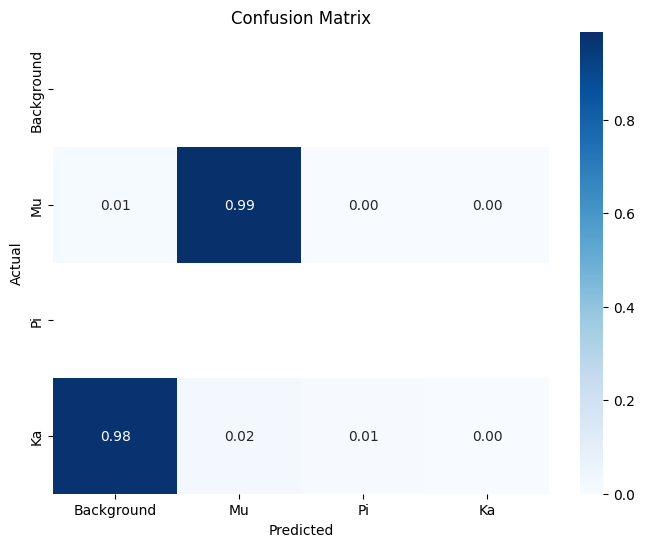

In [93]:
y_test_2 = label_encoder.transform(bdf[bdf.theta_p < 0.79].mass)
# y_pred_2 = model.predict(bdf[['momentum', 'unfixed_calculated_r_2d_4_rsigms_4_tsigms', 'theta_p', 'distance']])
y_pred_2 = label_encoder.transform(bdf[bdf.theta_p < 0.79].mass_reco)
cm = confusion_matrix(y_test_2, y_pred_2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

class_names = ['Background', 'Mu', 'Pi', 'Ka']
# Plotting using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()